In [346]:
import numpy as np
import pandas as pd

In [347]:
# Load data (3 csv)
mid_cap = pd.read_csv("mid_cap.csv")
large_cap = pd.read_csv("large_cap.csv")
us_agg = pd.read_csv("us_agg.csv")

print(mid_cap.shape)
print(large_cap.shape)
print(us_agg.shape) # 50 funds total # 18+12+20

(8705, 19)
(8705, 13)
(8705, 21)


In [348]:
# First column = dates = "as_of"
df = (
    mid_cap.merge(large_cap, on="as_of", how="inner")
           .merge(us_agg, on="as_of", how="inner")
)
df.shape

(8705, 51)

In [349]:
df.head()

,as_of,B12997,B01157,B09833,B06061,B11293,B05947,B13835,B14040,B04313,...,B13135,B06850,B00774,B00450,B03777,B05350,B02390,B15191,B06096,B11505
0,1/1/2000,13.9055,10.9340,24.5253,11.0364,22.4392,11.1366,54.3649,41.4075,43.6014,...,162.713,99.2692,38.2938,19.2007,14.3982,28.7085,94.4992,14.0622,5.35803,84.9581
1,1/2/2000,13.9055,10.9340,24.5253,11.0364,22.4392,11.1366,54.3649,41.4075,43.6014,...,162.713,99.2692,38.2938,19.2007,14.3982,28.7085,94.4992,14.0622,5.35803,84.9581
2,1/3/2000,13.5387,10.8173,24.0271,10.8301,21.9596,10.8743,54.3649,40.9984,43.7096,...,161.709,98.7015,38.2440,19.0980,14.3380,28.5579,93.8387,14.0068,5.30444,84.4768
3,1/4/2000,13.1163,10.4847,23.6001,10.5413,21.0429,10.6625,54.3649,39.4363,42.1809,...,162.197,99.0259,38.2440,19.1650,14.3681,28.6573,94.0148,14.0093,5.33659,84.7540
4,1/5/2000,13.1830,10.5431,23.8705,10.6650,20.9160,10.7432,54.3649,38.8412,42.5868,...,161.423,98.6204,38.0696,19.0623,14.3079,28.5379,93.3103,13.9539,5.29373,84.5060


In [350]:
# ensure first column is properly formatted # datetime
df['as_of'] = pd.to_datetime(df['as_of'], format='%m/%d/%Y')

In [351]:
df.head()

,as_of,B12997,B01157,B09833,B06061,B11293,B05947,B13835,B14040,B04313,...,B13135,B06850,B00774,B00450,B03777,B05350,B02390,B15191,B06096,B11505
0,2000-01-01,13.9055,10.9340,24.5253,11.0364,22.4392,11.1366,54.3649,41.4075,43.6014,...,162.713,99.2692,38.2938,19.2007,14.3982,28.7085,94.4992,14.0622,5.35803,84.9581
1,2000-01-02,13.9055,10.9340,24.5253,11.0364,22.4392,11.1366,54.3649,41.4075,43.6014,...,162.713,99.2692,38.2938,19.2007,14.3982,28.7085,94.4992,14.0622,5.35803,84.9581
2,2000-01-03,13.5387,10.8173,24.0271,10.8301,21.9596,10.8743,54.3649,40.9984,43.7096,...,161.709,98.7015,38.2440,19.0980,14.3380,28.5579,93.8387,14.0068,5.30444,84.4768
3,2000-01-04,13.1163,10.4847,23.6001,10.5413,21.0429,10.6625,54.3649,39.4363,42.1809,...,162.197,99.0259,38.2440,19.1650,14.3681,28.6573,94.0148,14.0093,5.33659,84.7540
4,2000-01-05,13.1830,10.5431,23.8705,10.6650,20.9160,10.7432,54.3649,38.8412,42.5868,...,161.423,98.6204,38.0696,19.0623,14.3079,28.5379,93.3103,13.9539,5.29373,84.5060


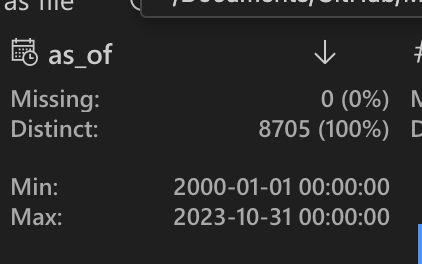

^^ Check these dates they don't match the project outline

In [352]:
df.shape

(8705, 51)

### Computing Returns

In [353]:
df = df.sort_values(by='as_of', ascending=False) # Sort descending newest -> oldest

prices = df.drop(columns='as_of') # Drop date col

def compute_returns(tau):
    tau = 365  # in yrs! 1,3 or 5 yrs
    future_prices = prices.shift(tau)

    returns = (future_prices - prices) / prices
    returns = returns.dropna() # Drop rows w/ NaN
    return returns

#print(returns.head(10))
#print(returns.tail(10))
r = compute_returns(365)
r.shape

(8340, 50)

In [354]:
r.head()

,B12997,B01157,B09833,B06061,B11293,B05947,B13835,B14040,B04313,B11222,...,B13135,B06850,B00774,B00450,B03777,B05350,B02390,B15191,B06096,B11505
8339,-0.019815,0.005134,-0.040486,0.020790,0.028214,-0.080507,0.025408,0.002316,0.002709,0.039353,...,0.003668,0.002329,0.018025,0.011794,-0.002444,0.032671,0.005478,0.027210,-0.011945,0.023863
8338,-0.030751,-0.005774,-0.053783,0.011176,0.009346,-0.092022,0.009146,-0.011779,-0.012571,0.032053,...,0.000032,-0.004238,0.018199,0.005454,-0.005739,0.031659,0.001590,0.023020,-0.013863,0.022235
8337,-0.037985,-0.012103,-0.061756,0.002900,0.006231,-0.099907,0.005371,-0.019461,-0.015372,0.030599,...,0.002064,-0.003099,0.019577,0.006627,-0.003571,0.033730,0.003085,0.022824,-0.009353,0.023873
8336,-0.037985,-0.012103,-0.061756,0.002900,0.006231,-0.099907,0.005371,-0.019461,-0.015372,0.030599,...,0.002064,-0.003099,0.019577,0.006627,-0.003571,0.033730,0.003085,0.022824,-0.009353,0.023873
8335,-0.025920,0.007103,-0.040509,0.021189,0.025397,-0.090350,0.025973,0.001795,0.000180,0.049238,...,0.000630,-0.005280,0.016637,0.003163,-0.006575,0.033839,0.002115,0.018818,-0.011175,0.022487


### Computing Rolling Returns

In [355]:
df = df.sort_values(by='as_of', ascending=False) # Sort descending newest -> oldest

prices = df.drop(columns='as_of') # Drop date col

tau = 365
delta = 5 

def compute_rolling_returns(tau,delta):
    rolling_returns = []
    T = len(prices)
    for t in range(0, T - tau, delta):  
        end_day = t + tau
        p_t = prices.iloc[t]
        p_end = prices.iloc[end_day]
        r = (p_end - p_t) / p_t
        rolling_returns.append(r)
    return pd.DataFrame(rolling_returns)

rolling_r = compute_rolling_returns(tau,delta)

In [356]:
rolling_r.head()

,B12997,B01157,B09833,B06061,B11293,B05947,B13835,B14040,B04313,B11222,...,B13135,B06850,B00774,B00450,B03777,B05350,B02390,B15191,B06096,B11505
0,0.020215,-0.005108,0.042194,-0.020366,-0.027439,0.087556,-0.024778,-0.002311,-0.002702,-0.037863,...,-0.003654,-0.002323,-0.017706,-0.011657,0.002450,-0.031637,-0.005449,-0.026489,0.012090,-0.023307
1,0.011585,-0.019936,0.027872,-0.034863,-0.027735,0.088445,-0.030519,-0.013946,-0.003699,-0.051221,...,-0.004404,-0.000195,-0.020269,-0.007841,0.001362,-0.038403,-0.006167,-0.026570,0.000234,-0.028354
2,-0.029406,-0.071374,-0.016101,-0.054249,-0.086568,0.017168,-0.088524,-0.067373,-0.071426,-0.111939,...,-0.012477,-0.006877,-0.026112,-0.013736,-0.004848,-0.047358,-0.013281,-0.034731,-0.015619,-0.036380
3,-0.096172,-0.135516,-0.086451,-0.110383,-0.164998,-0.045598,-0.163341,-0.117826,-0.144222,-0.209086,...,-0.015340,-0.007283,-0.026973,-0.012684,-0.007435,-0.054226,-0.019726,-0.039068,-0.016632,-0.038131
4,-0.092552,-0.129072,-0.072557,-0.106117,-0.166199,-0.044262,-0.153507,-0.115501,-0.136464,-0.202697,...,-0.016035,-0.012950,-0.027187,-0.012741,-0.008660,-0.054928,-0.022182,-0.039023,-0.020682,-0.038083


In [ ]:
# Verifying calculation is correct
tau = 365
delta = 5
roll_r = compute_rolling_returns(tau, delta)

T = len(prices)

L_theoretical = (T - tau + 1) // delta
L_actual = roll_r.shape[0]

print(f"T: {T}")
print(f"tau: {tau}")
print(f"delta: {delta}")
print(f"L_theory: {L_theoretical}")
print(f"L_actual: {L_actual}")

T: 8705
tau: 365
delta: 5
L_theory: 1668
L_actual: 1668
